# 1. Introduction

###  What is Ensemble Learning?

**Ensemble learning** is a paradigm in machine learning where multiple models (often called *weak learners*) are combined to form a stronger overall model. The key idea is that a group of weak models, when combined appropriately, can outperform any individual model.

Ensemble methods help to:
- Reduce **variance** (by averaging predictions – e.g., Bagging)
- Reduce **bias** (by focusing on misclassified samples – e.g., Boosting)
- Improve **generalization performance** on unseen data



### Why Does It Work?

Imagine asking the same question to multiple experts. If each one is prone to different types of mistakes, their combined opinion is often more reliable than a single expert’s view.

From a statistical perspective:
- Ensembles **reduce overfitting** and **improve robustness**
- They **average out errors** across models (especially helpful in high-variance models like decision trees)





# loading datasets


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer, load_iris, load_wine, make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For consistent results
RANDOM_STATE = 42

# NOTE to add additional libraries if you need them.

In [ ]:
# Helper function: Load and standardize dataset
def split_and_prepare_data(X, y, test_size=0.2, scale=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

# --- Dataset 1: Breast Cancer (binary classification) ---
cancer = load_breast_cancer()
X_cancer, y_cancer = cancer.data, cancer.target
X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = split_and_prepare_data(X_cancer, y_cancer)

# --- Dataset 2: Iris (3-class classification) ---
iris = load_iris()
X_iris, y_iris = iris.data, iris.target
X_iris_train, X_iris_test, y_iris_train, y_iris_test = split_and_prepare_data(X_iris, y_iris)

# --- Dataset 3: Wine (3-class classification, more complex) ---
wine = load_wine()
X_wine, y_wine = wine.data, wine.target
X_wine_train, X_wine_test, y_wine_train, y_wine_test = split_and_prepare_data(X_wine, y_wine)

# --- Dataset 4: Synthetic (binary classification) ---
X_synth, y_synth = make_classification(
    n_samples=1000, n_features=20, n_informative=10, n_redundant=5,
    n_classes=2, random_state=RANDOM_STATE
)
X_synth_train, X_synth_test, y_synth_train, y_synth_test = split_and_prepare_data(X_synth, y_synth)

# --- Dataset 5: make_moons (binary classification, visualization friendly) ---
X_moons, y_moons = make_moons(n_samples=500, noise=0.25, random_state=RANDOM_STATE)
X_moons_train, X_moons_test, y_moons_train, y_moons_test = split_and_prepare_data(X_moons, y_moons)


In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA

# Breast cancer dataset (reduced to 2D)
X_cancer_2d = PCA(n_components=2).fit_transform(cancer.data)
y_cancer_2d = cancer.target


iris = load_iris()
X_iris_2d = PCA(n_components=2).fit_transform(iris.data)
y_iris_2d = iris.target

In [ ]:
# you can ajdust the code for the plot function to your interest.
def plot_dataset(X, y):
    """
    Plots a 2D classification dataset with features on axes and classes color-coded

    Parameters:
    X : array-like, shape (n_samples, 2)
        Feature matrix
    y : array-like, shape (n_samples,)
        Class labels
    """
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm,
                          edgecolor='k', s=50, alpha=0.8)
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.title('2D Classification Dataset', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    legend = plt.legend(*scatter.legend_elements(),
                        title="Classes", loc='best')
    plt.gca().add_artist(legend)
    plt.show()



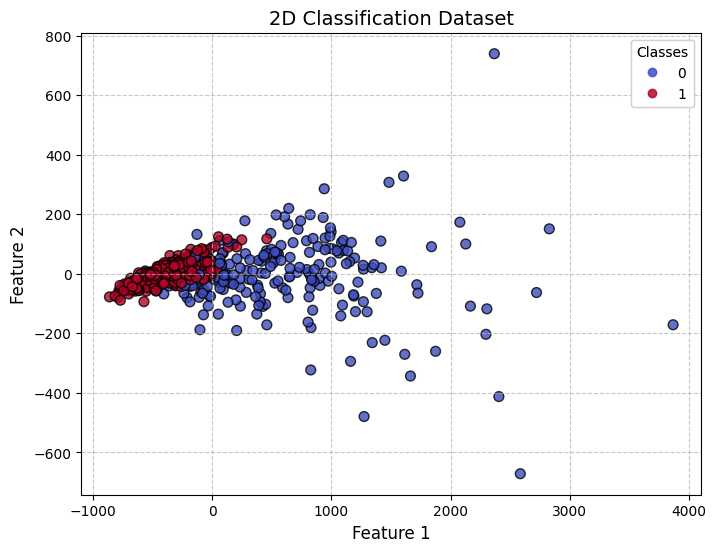

In [ ]:
plot_dataset(X_cancer_2d, y_cancer_2d)

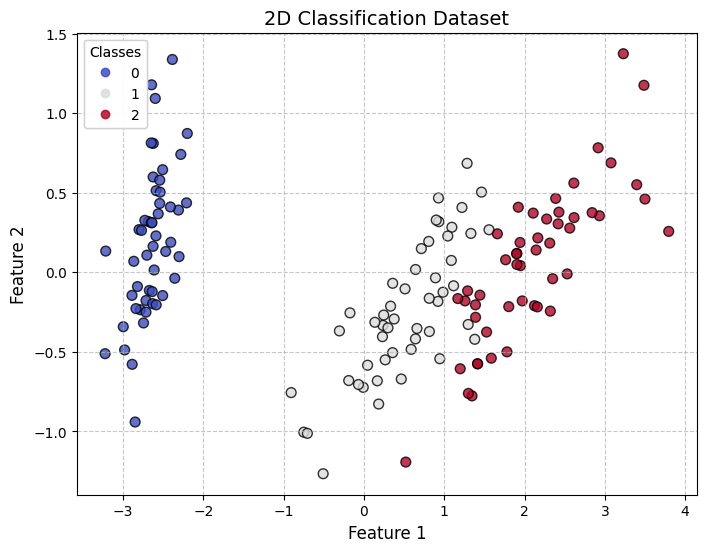

In [ ]:
plot_dataset(X_iris_2d, y_iris_2d)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


# Bagging Implementation (20 pts)

In this section, you will implement **Bagging (Bootstrap Aggregating)** from scratch.

you will start by building a very simple **Decision Tree Classifier** from scratch that can act as our *base learner*. Then use this weak learner inside a Bagging ensemble.

- Each decision tree is trained on a random bootstrap sample (with replacement) from the training data.
- The ensemble prediction is made by **majority voting** from all base learners.
- We'll evaluate the model on the **Breast Cancer** and **moons** datasets.

This approach will help solidify how bagging improves performance by reducing variance through averaging over different base learners.

**Step1:** Here we'll implement a very basic version of a decision tree that:
- Handles binary classification
- Splits on the best feature using Gini Impurity
- Stops based on max depth or pure node

This won't include pruning or advanced features — just enough to work as a weak learner.

In [ ]:
class DecisionTreeNode:
    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None

class SimpleDecisionTree:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.n_classes = None
        self.n_features = None
        self.tree = None

    def fit(self, X, y):
        self.n_classes = len(set(y))
        self.n_features = X.shape[1]
        self.tree = self._grow_tree(X, y)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _gini(self, y):
        m = len(y)
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes)]
        predicted_class = np.argmax(num_samples_per_class)
        node = DecisionTreeNode(
            gini=self._gini(y),
            num_samples=len(y),
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )

        if depth < self.max_depth and node.gini > 0:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _best_split(self, X, y):
        m, n = X.shape
        if m <= 1:
            return None, None

        best_gini = 1.0
        best_idx, best_thr = None, None

        for idx in range(n):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes
            num_right = [np.sum(classes == c) for c in range(self.n_classes)]
            for i in range(1, m):
                c = classes[i - 1]
                num_left[int(c)] += 1
                num_right[int(c)] -= 1

                gini_left = 1.0 - sum((num_left[x] / i) ** 2 for x in range(self.n_classes))
                gini_right = 1.0 - sum((num_right[x] / (m - i)) ** 2 for x in range(self.n_classes))
                gini = (i * gini_left + (m - i) * gini_right) / m

                if thresholds[i] == thresholds[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr

    def _predict(self, inputs):
        node = self.tree
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class


**step 2:** Here we'll implement Bagging Classifier from Scratch

This class will:
- Sample with replacement from the training set
- Train multiple decision trees (our weak learners)
- Use majority voting at prediction time

In [ ]:
from collections import Counter

class BaggingClassifier:
    def __init__(self, n_estimators=10, base_estimator_class=None, max_depth=3):
        self.base_estimator_class = base_estimator_class
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.models = []

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        self.models = []
        for _ in range(self.n_estimators):
            model = self.base_estimator_class(max_depth=self.max_depth)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        # Majority vote
        majority_votes = []
        for i in range(X.shape[0]):
            vote = Counter(predictions[:, i]).most_common(1)[0][0]
            majority_votes.append(vote)
        return np.array(majority_votes)


**Step 3:** Train and Evaluate

Now we’ll:
- Train the `BaggingClassifierScratch` on both datasets
- Measure accuracy on test sets


In [ ]:
from sklearn.metrics import accuracy_score

# Breast Cancer
print(" Breast Cancer Dataset")
bag_cancer = BaggingClassifier(base_estimator_class=SimpleDecisionTree,
                              n_estimators=20,
                              max_depth=2)
bag_cancer.fit(X_cancer_train, y_cancer_train)
y_pred_cancer = bag_cancer.predict(X_cancer_test)
print("Accuracy:", accuracy_score(y_cancer_test, y_pred_cancer))

# make_moons
print(" Make Moons Dataset")
bag_moons = BaggingClassifier(base_estimator_class=SimpleDecisionTree,
                            n_estimators=10,
                            max_depth=3)
bag_moons.fit(X_moons_train, y_moons_train)
y_pred_moons = bag_moons.predict(X_moons_test)
print("Accuracy:", accuracy_score(y_moons_test, y_pred_moons))


 Breast Cancer Dataset
Accuracy: 0.6228070175438597
 Make Moons Dataset
Accuracy: 0.44


# Boosting Implementation

### What is Boosting?

Boosting is an ensemble method that converts **weak learners** into a **strong learner** by training them sequentially. Unlike Bagging which trains in parallel and reduces variance, **Boosting focuses on reducing bias** by emphasizing the mistakes of prior models.

Each new learner is trained to **correct the errors** made by the previous ones. Over time, the ensemble becomes better and better at classification.

Boosting builds a series of models where each one learns from the mistakes of the previous. The final model is a weighted sum of the learners.


<!-- ### Visualization of Boosting Concept: -->

![Boosting Diagram](https://media.geeksforgeeks.org/wp-content/uploads/20210707140911/Boosting.png)

This image illustrates how each learner tries to "fix" what the previous one missed.


## How Does Gradient Boosting Work?

Gradient Boosting is a stage-wise additive model that minimizes a **loss function** by adding weak learners (typically decision trees) that point in the direction of the **negative gradient** of the loss.

### Conceptual Steps:

1. **Start with a constant prediction** (e.g., the log-odds for binary classification).
2. At each step `m`:
   - Compute **pseudo-residuals**: the gradient of the loss with respect to the current prediction.
   - Fit a weak learner (like a shallow decision tree) to predict these residuals.
   - Add the predictions to the model, scaled by a learning rate `η`.

### For Classification:
We typically use the **log-loss (cross-entropy)** for binary classification:

$$
\mathcal{L}(y, p) = - \left[y \log(p) + (1 - y) \log(1 - p)\right]
$$

For prediction:
$$
F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)
$$

Where:
- $ F_m(x) $: The boosted model at step m
- $ h_m(x) $: The weak learner at step m
- $ \eta $: Learning rate
- Residuals are gradients: $ r_i = - \frac{\partial \mathcal{L}}{\partial F(x_i)} $



We now implement a simple version of Gradient Boosting for binary classification.


**Step 1:** We'll implement a simplified version of gradient boosting that:
- Uses a shallow decision tree as the base learner
- Uses cross-entropy loss for binary classification
- Predicts in log-odds space (we use sigmoid to map predictions to probabilities)
- Sequentially adds trees to minimize residual error


In [ ]:
from scipy.special import expit  # Sigmoid function

class GradientBoostingClassifierScratch:
    def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []
        self.model_weights = []

    def _sigmoid(self, x):
        return expit(x)

    def fit(self, X, y):
        # Initialize model with log odds (prior)
        y = y.astype(int)
        p = np.clip(np.mean(y), 1e-5, 1 - 1e-5)
        Fm = np.full(y.shape, np.log(p / (1 - p)))

        self.models = []

        for m in range(self.n_estimators):
            # Compute gradients (residuals)
            prob = self._sigmoid(Fm)
            residuals = y - prob  # gradient of log loss

            # Fit regression tree to residuals
            tree = SimpleDecisionTree(max_depth=self.max_depth)
            tree.fit(X, residuals)
            prediction = np.array(tree.predict(X))

            # Update model
            Fm += self.learning_rate * prediction
            self.models.append(tree)

    def predict_proba(self, X):
        Fm = np.zeros(X.shape[0])
        for tree in self.models:
            Fm += self.learning_rate * np.array(tree.predict(X))
        prob = self._sigmoid(Fm)
        return np.vstack([1 - prob, prob]).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)


**Step 2:** Train & Evaluate

We'll now train our `GradientBoostingClassifierScratch` on:
- The **Breast Cancer** dataset (binary)
- The **make_moons** dataset (binary, nonlinear)

We evaluate using accuracy and inspect the improvement with more trees.


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

print("Breast Cancer Dataset (Gradient Boosting)")
gb_cancer = GradientBoostingClassifierScratch(n_estimators=10, learning_rate=0.1, max_depth=1)
gb_cancer.fit(X_cancer_train, y_cancer_train)
y_pred_cancer = gb_cancer.predict(X_cancer_test)
print("Accuracy:", accuracy_score(y_cancer_test, y_pred_cancer))
print("Confusion Matrix:")
print(confusion_matrix(y_cancer_test, y_pred_cancer))

print("Make Moons Dataset (Gradient Boosting)")
gb_moons = GradientBoostingClassifierScratch(n_estimators=10, learning_rate=0.1, max_depth=1)
gb_moons.fit(X_moons_train, y_moons_train)
y_pred_moons = gb_moons.predict(X_moons_test)
print("Accuracy:", accuracy_score(y_moons_test, y_pred_moons))
print("Confusion Matrix:")
print(confusion_matrix(y_moons_test, y_pred_moons))

Breast Cancer Dataset (Gradient Boosting)
Accuracy: 0.6228070175438597
Confusion Matrix:
[[ 0 43]
 [ 0 71]]
Make Moons Dataset (Gradient Boosting)
Accuracy: 0.57
Confusion Matrix:
[[ 0 43]
 [ 0 57]]


# AdaBoost: Adaptive Boosting

AdaBoost is a boosting technique that focuses on **reweighting** misclassified instances during training to force the learner to improve where it previously failed.


### Key Ideas:

1. **Sequential Training**: At each iteration, a new weak learner is trained on a weighted dataset.
2. **Sample Reweighting**: Examples misclassified by the current learner get **increased weight** so the next learner focuses more on them.
![AdaBoost Visual](https://miro.medium.com/v2/resize:fit:748/1*qzIPSA-HQlefxxZnPlb-2w.png)

this is a simple picture for 2d data to show how the reweighting happens in adaboost.

3. **Voting Scheme**: Final prediction is based on a **weighted vote** from all weak learners, with more accurate learners getting more say.

![AdaBoost Visual](https://slideplayer.com/slide/9092209/27/images/20/Algorithm+Adaboost+-+Example.jpg)

this is a simple scheme to show how the process of voting in adaboost


### Mathematical Formulation:

Assume a binary classification problem $ y_i \in \{-1, +1\} $

1. Initialize uniform weights:
   $$
   w_i^{(0)} = \frac{1}{N}
   $$

2. For each round $ t = 1 $ to $ T $:
   - Train a weak learner $ h_t $ using weights $ w_i $
   - Compute weighted error:
     $$
     \varepsilon_t = \frac{\sum_{i=1}^N w_i \cdot \mathbb{1}\left(h_t(x_i) \ne y_i\right)}{\sum w_i}
     $$
   - Compute model weight:
     $$
     \alpha_t = \frac{1}{2} \ln\left(\frac{1 - \varepsilon_t}{\varepsilon_t}\right)
     $$
   - Update weights:
     $$
     w_i \leftarrow w_i \cdot e^{-\alpha_t y_i h_t(x_i)}
     $$
     Normalize $$ w_i $$ so they sum to 1.


###  Why Exponential Loss?

AdaBoost minimizes the **exponential loss**:
$$
\mathcal{L} = \sum_i \exp\left(-y_i F(x_i)\right)
$$

Where $ F(x) = \sum_t \alpha_t h_t(x) $

This formulation explains the **reweighting** mechanism naturally:
- Misclassified samples get larger gradients (heavier weights).
- Boosting places more emphasis on harder examples.





**Step 1:** To integrate with AdaBoost, we must modify the decision tree to handle **weighted samples**.
This ensures:
- Misclassified points from previous rounds (which now have higher weights) influence the tree more.
- The impurity measures (like Gini) and split evaluation must use sample weights.

### What's Changed from the Original Tree?

- We introduce `sample_weight` as an argument in `fit()` and throughout tree-building methods.
- Gini impurity is now calculated using **weighted class proportions**:
  $$
  Gini = 1 - \sum_c \left( \frac{\sum w_i \cdot \mathbb{1}[y_i = c]}{\sum w_i} \right)^2
  $$
- The best split is selected by evaluating **weighted Gini impurity** on both sides.

This will allow us to use the tree as a base estimator for AdaBoost effectively.


In [ ]:
class WeightedDecisionTree:
    def __init__(self, max_depth=1):
        self.max_depth = max_depth
        self.classes_ = None
        self.n_classes = None
        self.n_features = None
        self.tree = None

    def fit(self, X, y, sample_weight=None):
        self.classes_ = np.unique(y)
        self.n_classes = len(self.classes_)
        self.n_features = X.shape[1]

        if sample_weight is None:
            sample_weight = np.ones(len(y)) / len(y)

        # Map y to 0-based indices
        y_mapped = np.searchsorted(self.classes_, y)
        self.tree = self._grow_tree(X, y_mapped, sample_weight, depth=0)

    def predict(self, X):
        indices = [self._predict(inputs) for inputs in X]
        return np.array([self.classes_[i] for i in indices])

    # ========== Internal Methods ==========
    def _gini(self, y_mapped, sample_weight):
        total_weight = np.sum(sample_weight)
        if total_weight == 0:
            return 0
        gini = 1.0
        for c in range(self.n_classes):
            p = np.sum(sample_weight[y_mapped == c]) / total_weight
            gini -= p ** 2
        return gini

    def _grow_tree(self, X, y_mapped, sample_weight, depth):
        num_samples_per_class = [
            np.sum(sample_weight[y_mapped == c]) for c in range(self.n_classes)
        ]
        predicted_class = np.argmax(num_samples_per_class)
        node = DecisionTreeNode(
            gini=self._gini(y_mapped, sample_weight),
            num_samples=len(y_mapped),
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )

        if depth < self.max_depth and node.gini > 0:
            idx, thr = self._best_split(X, y_mapped, sample_weight)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left, w_left = X[indices_left], y_mapped[indices_left], sample_weight[indices_left]
                X_right, y_right, w_right = X[~indices_left], y_mapped[~indices_left], sample_weight[~indices_left]

                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, w_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, w_right, depth + 1)
        return node

    def _best_split(self, X, y_mapped, sample_weight):
        m, n = X.shape
        if m <= 1:
            return None, None

        best_gini = 1.0
        best_idx, best_thr = None, None

        for idx in range(n):
            sorted_indices = X[:, idx].argsort()
            thresholds = X[sorted_indices, idx]
            classes = y_mapped[sorted_indices]
            weights = sample_weight[sorted_indices]

            w_left = np.zeros(self.n_classes)
            w_right = np.array([np.sum(weights[classes == c]) for c in range(self.n_classes)])
            total_weight = np.sum(weights)

            for i in range(1, m):
                c = classes[i - 1]
                w_left[c] += weights[i - 1]
                w_right[c] -= weights[i - 1]

                if thresholds[i] == thresholds[i - 1]:
                    continue

                w_left_sum = np.sum(weights[:i])
                w_right_sum = total_weight - w_left_sum

                if w_left_sum == 0 or w_right_sum == 0:
                    continue

                gini_left = 1.0 - np.sum((w_left / w_left_sum) ** 2)
                gini_right = 1.0 - np.sum((w_right / w_right_sum) ** 2)
                gini = (w_left_sum * gini_left + w_right_sum * gini_right) / total_weight

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2

        return best_idx, best_thr

    def _predict(self, inputs):
        node = self.tree
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

**Step 2:** Now We'll implement a simplified AdaBoost algorithm:
- Base learner: decision stumps (trees with depth 1)
- Use sample weights during training
- Update weights based on misclassifications
- Final prediction is a weighted majority vote

The core idea is to train models sequentially, reweighting data points each round.


In [ ]:
class AdaBoostClassifier:
    def __init__(self, n_estimators=10):
        self.n_estimators = n_estimators
        self.models = []
        self.model_weights = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        y = y.copy()
        # y[y == 0] = -1  # Convert labels to {-1, 1}
        w = np.full(n_samples, 1 / n_samples)

        for t in range(self.n_estimators):
            stump = WeightedDecisionTree(max_depth=1)
            stump.fit(X, y, sample_weight=w)

            pred = np.array(stump.predict(X))
            # pred[pred == 0] = -1  # Ensure predictions are {-1, 1}

            error = np.sum(w * (pred != y)) / np.sum(w)
            if error > 0.5:
                break

            alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
            w *= np.exp(-alpha * y * pred)
            w /= np.sum(w)

            self.models.append(stump)
            self.model_weights.append(alpha)

    def decision_function(self, X):
        """Returns raw decision scores before thresholding"""
        final_pred = np.zeros(X.shape[0])
        for model, alpha in zip(self.models, self.model_weights):
            pred = np.array(model.predict(X))
            # pred[pred == 0] = -1  # Ensure predictions are {-1, 1}
            final_pred += alpha * pred
        return final_pred

    def predict(self, X):
        return (self.decision_function(X) > 0).astype(int)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

def plot_dataset(X, y):
    """
    Plots a 2D classification dataset with features on axes and classes color-coded

    Parameters:
    X : array-like, shape (n_samples, 2)
        Feature matrix
    y : array-like, shape (n_samples,)
        Class labels
    """
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm,
                          edgecolor='k', s=50, alpha=0.8)
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.title('2D Classification Dataset', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    legend = plt.legend(*scatter.legend_elements(),
                        title="Classes", loc='best')
    plt.gca().add_artist(legend)
    plt.show()

In [ ]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0,
                          n_informative=2, n_clusters_per_class=1,
                          flip_y=0, random_state=42)
y = np.where(y == 0, -1, 1)  # Force labels to {-1, 1}

tree = WeightedDecisionTree(max_depth=1)
tree.fit(X, y)
preds = tree.predict(X)
print("Accuracy:", np.mean(preds == y))  # Should be > 0.95
print(confusion_matrix(y, preds))


Accuracy: 0.98
[[50  0]
 [ 2 48]]


In [ ]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0,
                          n_informative=2, n_clusters_per_class=1,
                          flip_y=0, random_state=42)

ada = AdaBoostClassifier(n_estimators=10)
ada.fit(X, y)
preds = ada.predict(X)
print("Accuracy:", np.mean(preds == y))  # Should be > 0.95
print(confusion_matrix(y, preds))

print(preds)
print(y)


Accuracy: 1.0
[[50  0]
 [ 0 50]]
[0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1
 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0
 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 1]
[0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1
 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0
 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 1]


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:2293: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


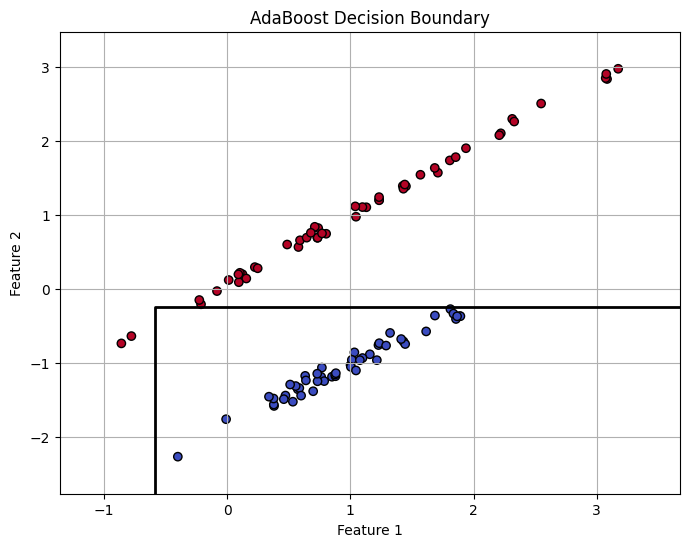

In [ ]:
def plot_decision_boundary(clf, X, y, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    # Get decision scores instead of class labels
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    # Use contourf with levels to show decision boundaries
    plt.contourf(xx, yy, Z, levels=[-np.inf, 0, np.inf], alpha=0.4, cmap='coolwarm')
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()


plot_decision_boundary(ada, X, y, title="AdaBoost Decision Boundary")


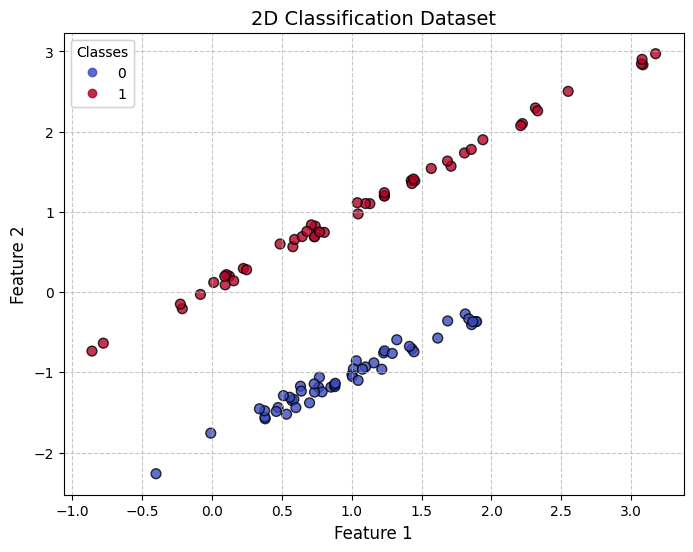

In [ ]:
plot_dataset(X, y)

## Training & Evaluation

We'll now test our AdaBoost implementation on:

1. Breast Cancer dataset (binary, high-dimensional)
2. make_moons dataset (binary, nonlinear)

We measure classification accuracy to evaluate performance.


In [ ]:
print("Breast Cancer Dataset (AdaBoost)")
ab_cancer = AdaBoostClassifier(n_estimators=10)
ab_cancer.fit(X_cancer_train, y_cancer_train)
y_pred_cancer = ab_cancer.predict(X_cancer_test)
print("Accuracy:", accuracy_score(y_cancer_test, y_pred_cancer))
print("Confusion Matrix:")
print(confusion_matrix(y_cancer_test, y_pred_cancer))

print("Make Moons Dataset (AdaBoost)")
ab_moons = AdaBoostClassifier(n_estimators=10)
ab_moons.fit(X_moons_train, y_moons_train)
y_pred_moons = ab_moons.predict(X_moons_test)
print("Accuracy:", accuracy_score(y_moons_test, y_pred_moons))
print("Confusion Matrix:")
print(confusion_matrix(y_moons_test, y_pred_moons))

Breast Cancer Dataset (AdaBoost)
Accuracy: 0.9210526315789473
Confusion Matrix:
[[35  8]
 [ 1 70]]
Make Moons Dataset (AdaBoost)
Accuracy: 0.87
Confusion Matrix:
[[40  3]
 [10 47]]


## Comparative Analysis: Random Forest (Bagging) vs AdaBoost

To compare the ensemble methods:
1. We'll use both `train` and `test` sets.
2. We'll evaluate:
   - Accuracy
   - Precision
   - Recall
   - F1 Score
   - Confusion Matrix
3. We'll also visualize how performance evolves with number of estimators (`n_estimators`):
   - Training vs Test error across ensemble size.

This helps us understand:
- How bias-variance trade-off changes with more trees.
- Which method generalizes better or overfits.

We'll compare using:
- Breast Cancer dataset
- make_moons dataset (nonlinear boundary)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("Train classification report:")
    print(classification_report(y_train, y_train_pred))
    print("Test classification report:")
    print(classification_report(y_test, y_test_pred))

    return {
        "train_accuracy": accuracy_score(y_train, y_train_pred),
        "test_accuracy": accuracy_score(y_test, y_test_pred),
        "train_precision": precision_score(y_train, y_train_pred),
        "test_precision": precision_score(y_test, y_test_pred),
        "train_recall": recall_score(y_train, y_train_pred),
        "test_recall": recall_score(y_test, y_test_pred),
        "train_f1": f1_score(y_train, y_train_pred),
        "test_f1": f1_score(y_test, y_test_pred),
        "train_confusion": confusion_matrix(y_train, y_train_pred),
        "test_confusion": confusion_matrix(y_test, y_test_pred),
    }


In [ ]:
def plot_errors_vs_estimators(model_class, model_name, X_train, y_train, X_test, y_test, estimator_range, **kwargs):
    train_errors = []
    test_errors = []

    for n in estimator_range:
        model = model_class(n_estimators=n, **kwargs)
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_error = 1 - accuracy_score(y_train, y_train_pred)
        test_error = 1 - accuracy_score(y_test, y_test_pred)

        train_errors.append(train_error)
        test_errors.append(test_error)

    plt.figure(figsize=(8, 5))
    plt.plot(estimator_range, train_errors, label='Train Error')
    plt.plot(estimator_range, test_errors, label='Test Error')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Error Rate')
    plt.title(f'{model_name} Performance vs Estimators')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def plot_confusion_matrices(results_bagging, results_boosting):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, title, cm in zip(axes, ['Random Forest (Bagging)', 'AdaBoost'],
                              [results_bagging["test_confusion"], results_boosting["test_confusion"]]):
        ax.matshow(cm, cmap='Blues', alpha=0.8)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
        ax.set_title(title)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    plt.tight_layout()
    plt.show()



### Question:

Imagine you observe that AdaBoost achieves lower training error faster than Random Forest, but its test error starts increasing after some point.

**Q:** What does this suggest about AdaBoost's bias-variance characteristics compared to Random Forest, and how would you decide when to stop adding estimators?

(Hint: Think about overfitting tendencies and how ensemble diversity affects generalization.)

```

AdaBoost's faster training error reduction but eventual test error increase suggests it has lower bias but higher variance than Random Forest. The sequential nature of AdaBoost causes it to overfit noisy samples as more estimators are added, while Random Forest's independent trees maintain better generalization through diversity.

To prevent overfitting, stop adding AdaBoost estimators when the validation error stops improving (typically after 5-10 rounds of no gain). Use early stopping or monitor the gap between training and test performance—once the test error starts rising, the model is overfitting. Random Forest rarely needs this tuning, as it naturally resists overfitting via bagging.
```



## 8. Visualizations

- **Plot decision boundaries**: Helps visually understand how AdaBoost evolves its decision surface, especially on simple 2D datasets like `make_moons`.
- **Feature importance**: Though not a core property of AdaBoost from scratch, we can estimate feature importance by counting how often and how early each feature is used in weak learners.

### Implementation:
- We'll create a meshgrid to plot the classifier's predictions across 2D space.
- For feature importance, we'll extract which features are chosen at each stage and assign more weight to earlier, more influential weak learners.


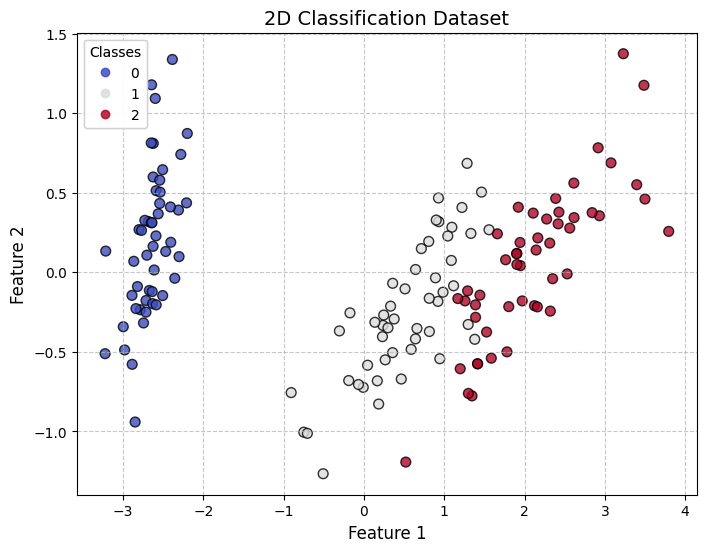

In [ ]:
iris = load_iris()
X_iris_2d = PCA(n_components=2).fit_transform(iris.data)
y_iris_2d = iris.target

plot_dataset(X_iris_2d, y_iris_2d)

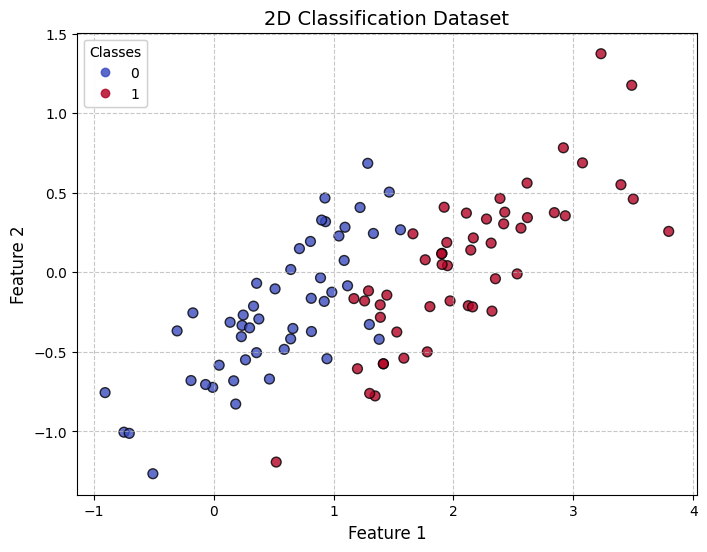

In [ ]:
# Remove class 0 (setosa)
mask = y_iris_2d != 0
X_iris_binary = X_iris_2d[mask]
y_binary = y_iris_2d[mask]

# Remap classes (1→0, 2→1)
y_iris_binary = np.where(y_binary == 1, 0, 1)

plot_dataset(X_iris_binary, y_iris_binary)

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:2293: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


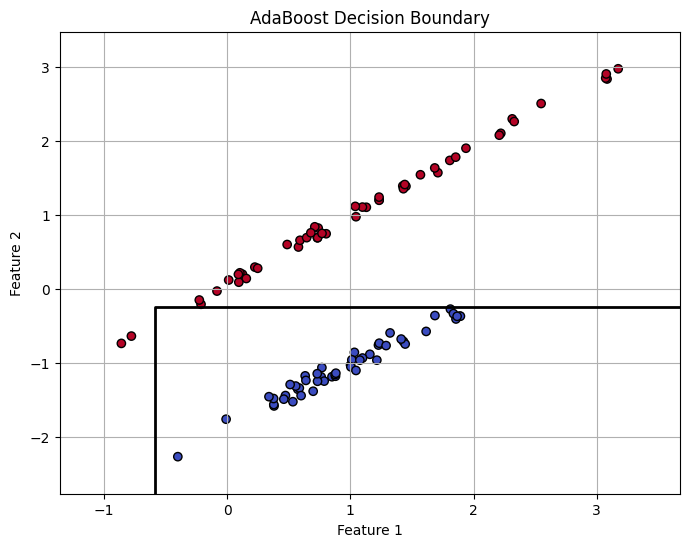

In [ ]:
plot_decision_boundary(ada, X, y, title="AdaBoost Decision Boundary")


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:2293: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


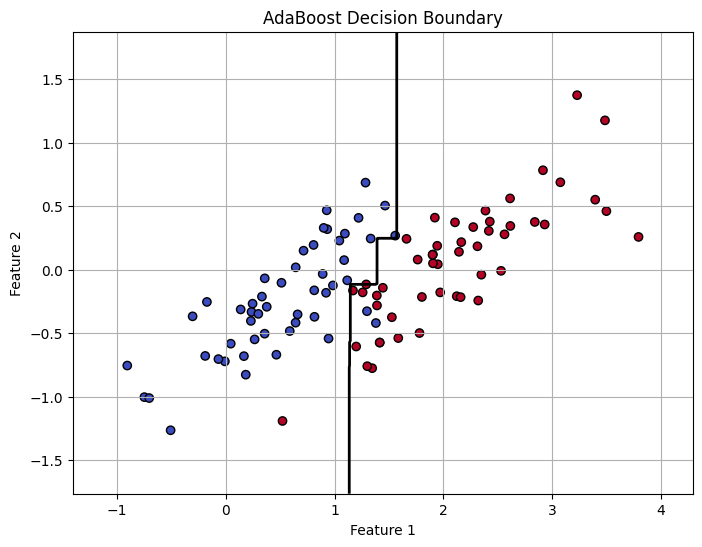

In [ ]:
iris = load_iris()
X_iris_2d = PCA(n_components=2).fit_transform(iris.data)
y_iris_2d = iris.target
# Remove class 0 (setosa)
mask = y_iris_2d != 0
X_iris_binary = X_iris_2d[mask]
y_binary = y_iris_2d[mask]

# Remap classes (1→0, 2→1)
y_iris_binary = np.where(y_binary == 1, 0, 1)
ada = AdaBoostClassifier(n_estimators=10)
y_iris_binary = np.where(y_iris_binary == 0, -1, 1)  # Force labels to {-1, 1}

ada.fit(X_iris_binary, y_iris_binary)

preds = ada.predict(X_iris_binary)


plot_decision_boundary(ada, X_iris_binary, y_iris_binary, title="AdaBoost Decision Boundary")



### 💡 Question

In the decision boundary plot, how does AdaBoost adapt its boundary around noisy samples? What happens if we increase the number of estimators too much? How does this relate to the risk of overfitting?

```
AdaBoost aggressively adapts its decision boundary to correct misclassified (noisy) samples by increasing their weights, causing later estimators to focus heavily on them. This creates complex, wiggly boundaries around noisy points.

If we use too many estimators, AdaBoost overfits by:

Over-emphasizing noise (fitting outliers)

Losing generalization (boundary becomes too specific to training data)

The risk? High variance—great on training data but poor on unseen data. Early stopping or reducing estimator count helps prevent this.

(Key: AdaBoost's strength—adaptability—becomes its weakness when overdone!)
```


# Bonus: XGBoost Comparison

### Why Compare with XGBoost?

XGBoost (Extreme Gradient Boosting) is one of the most powerful and widely-used boosting algorithms due to its:
- Efficiency (parallelization, optimized memory usage)
- Flexibility (regularization, custom loss functions)
- Scalability (can handle very large datasets)

### Core Concepts:

1. **Gradient Boosting Foundation**: Like AdaBoost, XGBoost builds trees sequentially. But instead of exponential loss, it minimizes a **regularized objective**:
   $$
   \mathcal{L}(t) = \sum_i \ell(y_i, \hat{y}_i^{(t)}) + \sum_k \Omega(f_k)
   $$
   where $ \Omega(f) = \gamma T + \frac{1}{2}\lambda \sum w_j^2 $

2. **Second-order Approximation**: Uses **both gradients and Hessians** to guide tree construction.

3. **Regularization**: Helps prevent overfitting, unlike traditional gradient boosting.

4. **Shrinkage (learning rate)** and **column subsampling** are used to improve generalization.


### We'll evaluate XGBoost on:
- `make_moons`: for 2D decision boundaries
- `breast_cancer`: to compare classification performance



In [ ]:
!pip install xgboost

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


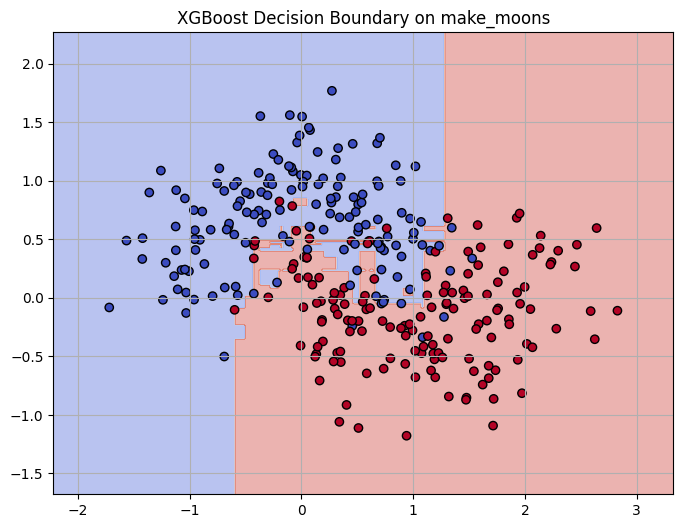

In [ ]:
from xgboost import XGBClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Dataset
X, y = make_moons(n_samples=300, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=50)
xgb.fit(X_train, y_train)

# Decision boundary plot
def plot_xgb_boundary(model, X, y, title="XGBoost Decision Boundary"):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_xgb_boundary(xgb, X, y, title="XGBoost Decision Boundary on make_moons")


In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import numpy as np

# Load and split data
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100)
xgb.fit(X_train, y_train)

# Evaluate
y_pred = xgb.predict(X_test)
print("XGBoost Classification Report (Breast Cancer):")
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report (Breast Cancer):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        54
           1       0.97      0.97      0.97        89

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143

